In [4]:
import pandas_datareader.data as reader
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as sm

import yfinance as yf

# Estimating CAPM

In this notebook you'll learn how to estimate stock betas. Recall that beta is a measure of a stock's volatilty with respect to the market. The CAPM equation is given by

$$ R_i - R_f = \alpha + \beta[R_m - R_f] $$

Where $R_i$ is the return of a stock over a period of time. $R_f$ is the risk-free rate of return over the same period, and $R_m$ is the market return over the same period. The term $R_i - R_f$ is often called the "excess return" and the factor $R_m - R_f$, the "market excess return". .

A key question for us is how do we obtain $\beta$? 

Notice that the CAPM formula neatly forms a linear regression equation. We could rewrite it as 

$$ R_i - R_f = \alpha + \beta_i[R_m - R_f] + \varepsilon_i $$

So all we need to do is regress past returns for the stock against past returns for the market, and the coefficient from this regression should be the stock's beta.

## Procedure

Because we can always calculate returns over an arbitrary period, it is critical that we choose the frequency of the data before estimating beta. Daily (and higher) frequecy for calculating returns tends to be very noisy and leads to less reliable estimation. The usual practice in financial modeling is to calculate returns at a monthly frequency and use at least 5 years (60 observations) to carry out our models.

Notice that our CAPM models always specify an intercept, so we too will always want to make sure our models include an intercept. 

## Example - Microsoft

Let's calculate a beta for Microsoft. We're using a convenient API that will download stock price data directly from Yahoo! Finance called `yfinance`, imported above. We'll also need a data scraper `pandas_datareader` to get the risk-free rate (usually assumed to be equal to the rate on a 10-year US T-bond) which is conveniently available from Ken French's website. 

Let's start by specifying our time parameters and download the data. (Note the tag `^GSPC` is just how yfinance records the return on the S&P 500, which is what we'll use as a proxy for the market return). 

In [151]:
end = dt.datetime.now()
start = dt.date(end.year - 5, end.month, end.day)
data_input = ['msft' , '^GSPC']

In [153]:
raw_df = yf.download(data_input, start=start, end=end)
raw_df.head()

[*********************100%%**********************]  2 of 2 completed


Price        Adj Close                    Close                     High  \
Ticker            MSFT        ^GSPC        MSFT        ^GSPC        MSFT   
Date                                                                       
2019-04-10  114.407936  2888.209961  120.190002  2888.209961  120.349998   
2019-04-11  114.541214  2888.320068  120.330002  2888.320068  120.849998   
2019-04-12  115.131386  2907.409912  120.949997  2907.409912  120.980003   
2019-04-15  115.226555  2905.580078  121.050003  2905.580078  121.580002   
2019-04-16  114.960014  2907.060059  120.769997  2907.060059  121.650002   

Price                           Low                     Open               \
Ticker            ^GSPC        MSFT        ^GSPC        MSFT        ^GSPC   
Date                                                                        
2019-04-10  2889.709961  119.540001  2879.129883  119.760002  2881.370117   
2019-04-11  2893.419922  119.919998  2881.989990  120.540001  2891.919922   
2019-04-12  2910.540039  120.370003  2898.370117  120.639999  2900.860107   
2019-04-15  2909.600098  120.570000  2896.479980  120.940002  2908.320068   
2019-04-16  2916.060059  120.099998  2900.709961  121.639999  2912.260010   

Price         Volume              
Ticker          MSFT       ^GSPC  
Date                              
2019-04-10  16477200  3092230000  
2019-04-11  14209100  2970650000  
2019-04-12  19745100  3726050000  
2019-04-15  15792600  3114530000  
2019-04-16  14071800  3403120000

The dataframe contains a bunch of information including adjusted closing prices, high and low for the day, and volume for the day for both MSFT and for the SP500 every day for the last 5 years.

We'll only need the adjusted close, so let's select that out. 

In [154]:
df = raw_df['Adj Close']
df

Ticker,MSFT,^GSPC
Date,,
2019-04-10,114.407936,2888.209961
2019-04-11,114.541214,2888.320068
2019-04-12,115.131386,2907.409912
2019-04-15,115.226555,2905.580078
2019-04-16,114.960014,2907.060059
...,...,...
2024-04-04,417.880005,5147.209961
2024-04-05,425.519989,5204.339844
2024-04-08,424.589996,5202.390137


Next we need to calculate returns. As we mentioned the standard practice is to use monthly returns which tend to be more stable, so let's transform our daily prices into monthly returns using the function `pd.resample()`. (for a full discussion on this method - see the documentation here: https://pandas.pydata.org/docs/reference/api/pandas.core.resample.Resampler.ffill.html) 

In [157]:
m_ret = df.resample('M').ffill().pct_change()
m_ret

Ticker,MSFT,^GSPC
Date,,
2019-04-30,NaN,NaN
2019-05-31,-0.049481,-0.065778
2019-06-30,0.083118,0.068930
2019-07-31,0.017244,0.013128
2019-08-31,0.015037,-0.018092
...,...,...
2023-12-31,-0.007574,0.044229
2024-01-31,0.057281,0.015896
2024-02-29,0.042318,0.051721


As you can see we lose the first observation - this is natural because there's nothing to calculate a percentage change relative to. We'll just drop this row so it doesn't cause any issues.

In [158]:
m_ret = m_ret.dropna(axis = 0)
m_ret

Ticker,MSFT,^GSPC
Date,,
2019-05-31,-0.049481,-0.065778
2019-06-30,0.083118,0.068930
2019-07-31,0.017244,0.013128
2019-08-31,0.015037,-0.018092
2019-09-30,0.008487,0.017181
2019-10-31,0.031216,0.020432
2019-11-30,0.059462,0.034047
2019-12-31,0.041749,0.028590
2020-01-31,0.079455,-0.001628


Let's also rename our columns so they don't confuse us.

In [162]:
m_ret.columns = ['msft', 'sp500']

In [163]:
m_ret.head()

,msft,sp500
Date,,
2019-05-31,-0.049481,-0.065778
2019-06-30,0.083118,0.068930
2019-07-31,0.017244,0.013128
2019-08-31,0.015037,-0.018092
2019-09-30,0.008487,0.017181


### Regression

Here let's carry out the regression using `statsmodels` like we did before. Don't forget to include your constant term. `statsmodels` makes you specify it manually, so we include that with `sm.add_constant()`.

In [164]:
X = m_ret['sp500']
y = m_ret['msft']

X_sm = sm.add_constant(X)

In [165]:
#setup model
model = sm.OLS(y, X_sm)

In [166]:
#fit model
res = model.fit()

In [167]:
#report results
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   msft   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     72.24
Date:                Wed, 10 Apr 2024   Prob (F-statistic):           8.96e-12
Time:                        19:22:29   Log-Likelihood:                 106.20
No. Observations:                  60   AIC:                            -208.4
Df Residuals:                      58   BIC:                            -204.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0131      0.006      2.364      0.021       0.002       0.024
sp500          0.8753      0.103      8.500      0.000       0.669       1.081
==============================================================================
Omnibus:                        4.940   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.085   Jarque-Bera (JB):                4.381
Skew:                           0.659   Prob(JB):                        0.112
Kurtosis:                       3.114   Cond. No.                         19.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The covariates are included in the attribute `params`. This suggests Microsoft has a beta of 0.88 - slightly less risky than the market return as a whole. 

A quick check of Yahoo! Finance confirms our beta estimate is right on target.

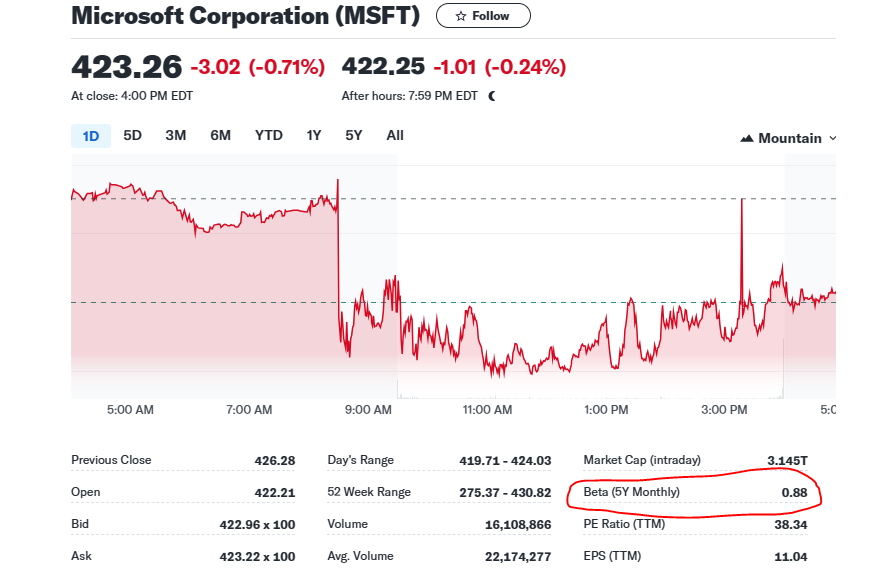

In [169]:
res.params

const    0.013060
sp500    0.875305
dtype: float64

Here we can plot the regression line, just to check things out. Everything looks fine here.

In [121]:
import seaborn as sns

<AxesSubplot:xlabel='sp500', ylabel='msft'>

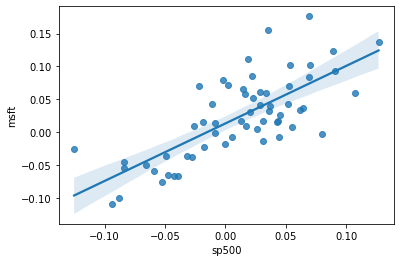

In [122]:
sns.regplot(x = 'sp500', y = 'msft', data = m_ret)

## Including the risk free rate

Notice that we didn't include the risk-free rate above. Let's do that here. We'll use our data scraper tool on Ken French's website which contains a lot of useful information and can be found here: https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html. More on this later in the course. 

In [170]:
rf = reader.DataReader('F-F_Research_Data_Factors', 'famafrench', start, end)[0].RF
rf

Date
2019-04    0.21
2019-05    0.21
2019-06    0.18
2019-07    0.19
2019-08    0.16
2019-09    0.18
2019-10    0.16
2019-11    0.12
2019-12    0.14
2020-01    0.13
2020-02    0.12
2020-03    0.13
2020-04    0.00
2020-05    0.01
2020-06    0.01
2020-07    0.01
2020-08    0.01
2020-09    0.01
2020-10    0.01
2020-11    0.01
2020-12    0.01
2021-01    0.01
2021-02    0.00
2021-03    0.00
2021-04    0.00
2021-05    0.00
2021-06    0.00
2021-07    0.00
2021-08    0.00
2021-09    0.00
2021-10    0.00
2021-11    0.00
2021-12    0.01
2022-01    0.00
2022-02    0.00
2022-03    0.01
2022-04    0.01
2022-05    0.03
2022-06    0.06
2022-07    0.08
2022-08    0.19
2022-09    0.19
2022-10    0.23
2022-11    0.29
2022-12    0.33
2023-01    0.35
2023-02    0.34
2023-03    0.36
2023-04    0.35
2023-05    0.36
2023-06    0.40
2023-07    0.45
2023-08    0.45
2023-09    0.43
2023-10    0.47
2023-11    0.44
2023-12    0.43
2024-01    0.47
2024-02    0.42
Freq: M, Name: RF, dtype: float64

The data isn't quite up to date and is backdated by a month, so we'll have to trim the data in order to match the months correctly. Notice we have an observation from April, 2019 that we don't have returns for, so let's drop that from the `rf` series.

In [172]:
#remove first row due to mismatch
rf = rf[1:]

And we don't have risk free rates for the last two months of our returns data, so let's drop those.

In [173]:
#remove last rows due to missing data
mt_ret_rf = m_ret[:-2]

Finally, let's calculate our market excess factors.

In [178]:
mt_ret_rf['msft-rf'] = mt_ret_rf['msft'] - rf.values
mt_ret_rf['sp500-rf'] = mt_ret_rf['sp500'] - rf.values

C:\Users\HARLAN~1\AppData\Local\Temp/ipykernel_7268/2511792174.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mt_ret_rf['msft-rf'] = mt_ret_rf['msft'] - rf.values
C:\Users\HARLAN~1\AppData\Local\Temp/ipykernel_7268/2511792174.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mt_ret_rf['sp500-rf'] = mt_ret_rf['sp500'] - rf.values


In [179]:
mt_ret_rf.head()

,msft,sp500,msft-rf,sp500-rf
Date,,,,
2019-05-31,-0.049481,-0.065778,-0.259481,-0.275778
2019-06-30,0.083118,0.068930,-0.096882,-0.111070
2019-07-31,0.017244,0.013128,-0.172756,-0.176872
2019-08-31,0.015037,-0.018092,-0.144963,-0.178092
2019-09-30,0.008487,0.017181,-0.171513,-0.162819


Next let's redo the regression the same way we did the first one.

In [180]:
X = mt_ret_rf['sp500-rf']
y = mt_ret_rf['msft-rf']

X_sm = sm.add_constant(X)

In [181]:
model_rf = sm.OLS(y, X_sm)

In [182]:
res_rf= model_rf.fit()

In [183]:
res_rf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                msft-rf   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     901.9
Date:                Wed, 10 Apr 2024   Prob (F-statistic):           3.25e-36
Time:                        19:33:18   Log-Likelihood:                 101.71
No. Observations:                  58   AIC:                            -199.4
Df Residuals:                      56   BIC:                            -195.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0072      0.007      0.995      0.324      -0.007       0.022
sp500-rf       0.9671      0.032     30.031      0.000       0.903       1.032
==============================================================================
Omnibus:                        3.150   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.207   Jarque-Bera (JB):                2.530
Skew:                           0.508   Prob(JB):                        0.282
Kurtosis:                       3.121   Cond. No.                         5.87
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [184]:
res_rf.params

const       0.007223
sp500-rf    0.967084
dtype: float64

Including the risk-free rate changed our beta calculation quite a bit! Now our beta is around 0.96 - riskier than we calculated from before. This should highlight how important it is to include this in the regression, especially now since the risk free rates are much above zero. 

## Exercise

Try this on your own! Select a few stocks and start calculating betas for them. Next week we'll examine how to use these to predict market returns and identify abnormal returns over a prediction period. 